<a href="https://colab.research.google.com/github/cseprasadpawar/Pneumonia_Detection/blob/master/pneumonia_detection_using_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import os
import argparse

import random

import time
import datetime

from collections import Counter

import numpy as np
import pandas as pd

import shutil
from tqdm import tqdm

import inspect
import gc

import re

from PIL import Image
import cv2

import keras

from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense


from keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions


from keras.constraints import maxnorm


from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop


from keras import backend as K
K.tensorflow_backend.set_image_dim_ordering('th')



from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf



from IPython.display import display

import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [106]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cseprasadpawar","key":"ab5954affb8d42921915a7a13d5d48f3"}'}

In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
# List available datasets.
!kaggle datasets list -s chest_xray

ref                                     title                           size  lastUpdated          downloadCount  
--------------------------------------  ------------------------------  ----  -------------------  -------------  
paultimothymooney/chest-xray-pneumonia  Chest X-Ray Images (Pneumonia)   2GB  2018-03-24 19:41:59          25088  
muzin11/chest-xray-image                Chest X-ray image                1GB  2019-09-03 01:55:22             15  


In [12]:
# Copy the stackoverflow data set locally.
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

!ls /content

100% 2.29G/2.29G [00:18<00:00, 81.3MB/s]
100% 2.29G/2.29G [00:18<00:00, 131MB/s] 
chest-xray-pneumonia.zip  drive  kaggle.json  sample_data


In [13]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0010-0001.jpeg  
  inflating: chest_x

In [29]:
!ls chest_xray

test  train  val


In [30]:
!rm -r chest_xray/__MACOSX chest_xray/chest_xray
!rm chest-xray-pneumonia.zip
!ls
!ls chest_xray

rm: cannot remove 'chest_xray/__MACOSX': No such file or directory
rm: cannot remove 'chest_xray/chest_xray': No such file or directory
chest_xray  drive  kaggle.json	sample_data
test  train  val


In [33]:
!mkdir output
!mkdir output/figures
!mkdir output/figures/result
!mkdir output/figures/sample
!ls output
!ls output/figures

mkdir: cannot create directory ‘output’: File exists
mkdir: cannot create directory ‘output/figures’: File exists
figures


In [0]:

##reset_graph()
##reset_callbacks()

# Configure input/ output directory
# Configure training, validation, testing directory

input_dir = r"chest_xray/"
output_dir = r"output/"

training_dir = input_dir + r"train"
validation_dir = input_dir + r"val"
testing_dir = input_dir + r"test"


figure_dir = r"/content/output/figures"
  
    
file_name_pred_batch = figure_dir+r"/result"
file_name_pred_sample = figure_dir+r"/sample"

Number of Class:  2
-------------------------------------------------------Pneumonia-------------------------------------------------------


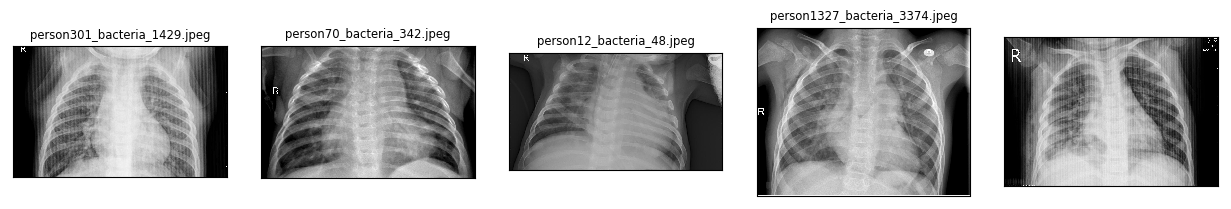


-------------------------------------------------------Normal-------------------------------------------------------


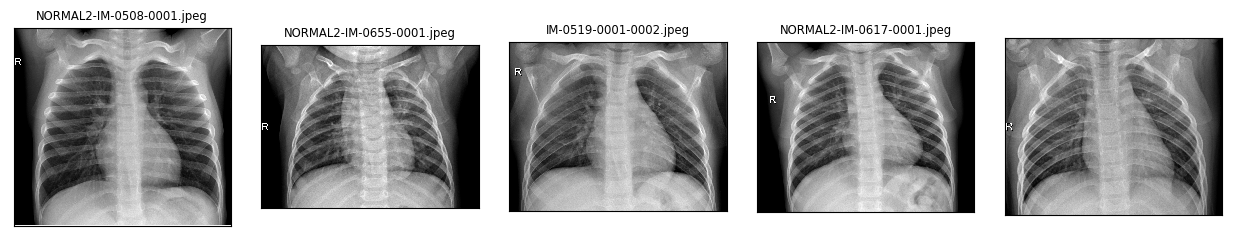


-------------------------------------------------------All Class Printed:2-------------------------------------------------------


In [108]:
show_class_sample_images(training_dir, image_count_per_category=5, save=False, dpi=100, update_image=False)

In [0]:
'''
Mandatory:
dataset: string, dataset from where we extract images
category: string, category within the dataset (NORMAL, PNEUMONIA)

Optional:
labeled: boolean, determine if images should be labeled
sample_size: int, number of images to display
'''
def plot_img(subset, category, labeled = False, sample_size = 6):
  
  #full_path = dataset_path + subset + '/' + category
  full_path = input_dir + subset + '/' + category 
  # Check if sample_size is valid
  if (sample_size > len([file for file in os.listdir(full_path)])):
      print(len([file for file in os.listdir('.') if os.path.isfile(file)]))
      print("Not enough files in ", full_path)
      return
    
  # Define the figure size
  plt.figure(figsize=(18, 12))
  
  for i, file in enumerate(os.listdir(full_path)):

    # Check if number of images to display has been reached
    if(i >= sample_size):
      break
    img = mpimg.imread(full_path + '/' + file)
    plt.subplot(231 + i)

    if labeled:
      plt.title(file.split('-')[1])
    
    plt.imshow(img)

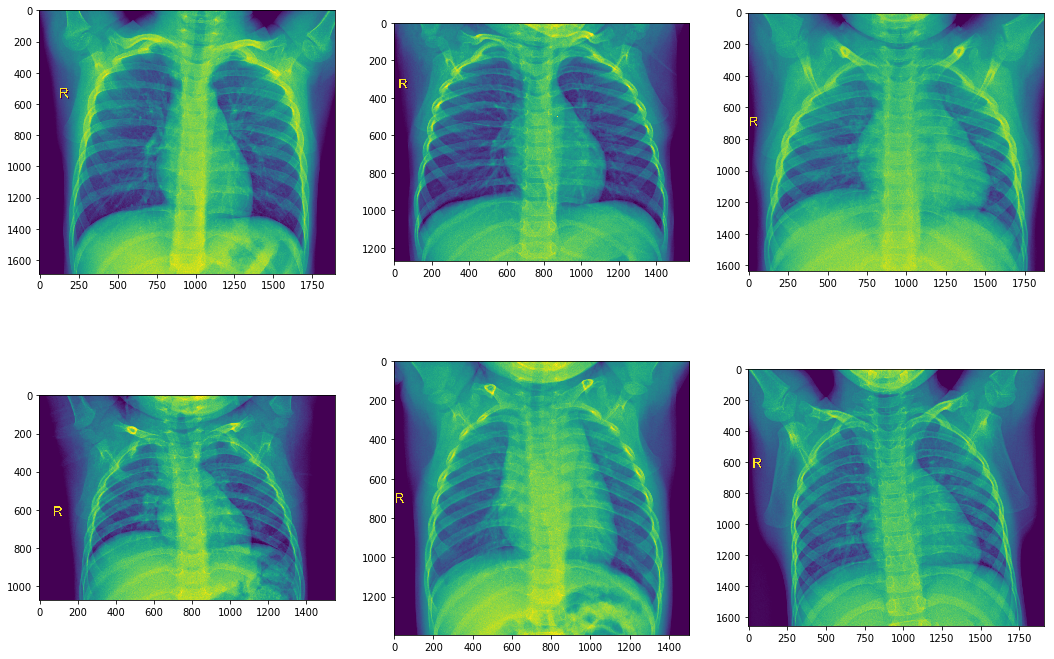

In [42]:
# Calling the above function
plot_img("train", "NORMAL")

In [0]:
def compare_img(subset, labeled = False):
  path = input_dir + subset
  
  # Taking a random sample from both the PNEUMONIA and the NORMAL directory
  random_pneumonia = np.random.choice(os.listdir(path + "/PNEUMONIA"))
  random_normal = np.random.choice(os.listdir(path + "/NORMAL"))
  
  # Figure size
  fig=plt.figure(figsize=(16, 16))


  # Displaying images
  a = fig.add_subplot(1, 2, 1)
  normal = mpimg.imread(path + "/NORMAL/" + random_normal)
  image1 = plt.imshow(normal)
  
  
  # Option to show the label 
  if labeled:
    a.set_title('NORMAL')
    
  a = fig.add_subplot(1, 2, 2)
  pneumonia = mpimg.imread(path + "/PNEUMONIA/" + random_pneumonia)
  image2 = plt.imshow(pneumonia)
  
  # Option to show the label 
  if labeled:
    a.set_title('PNEUMONIA')
  

  plt.show()

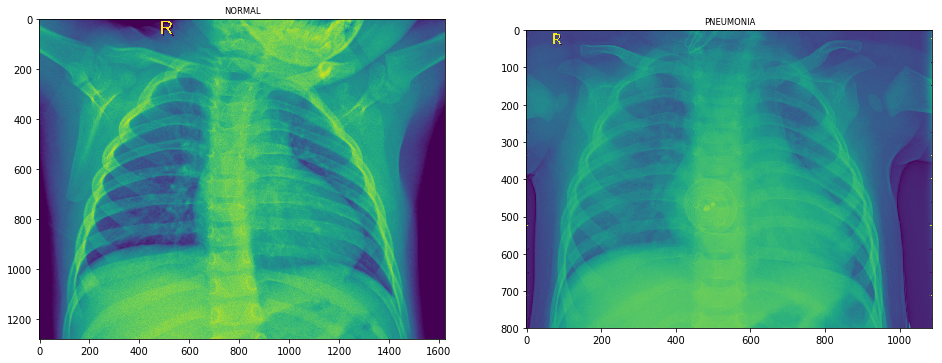

In [44]:
# Let's compare one image showasing pneumonia and one normal
compare_img("train", labeled = True)

In [70]:
# batch_size = 32

# target_size = (299, 299)
# color_mode = "rgb"


rescale = 1./255
target_size = (150, 150)
batch_size = 128
class_mode = "categorical"
# class_mode = "binary"


train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

val_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(validation_dir),
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(testing_dir),
    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [110]:
# count for class instances in training data

class1_train = sum(train_generator.classes)
class0_train = len(train_generator.classes) - class1_train

print("Pneumonia - %i, Normal - %i" % (class0_train, class1_train))

Pneumonia - 1341, Normal - 3875


**Trianing Model**

In [0]:
base_model = InceptionV3(weights='imagenet', include_top=False)

'''
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
#predictions = keras.layers.Dense(2, activation='softmax')(x)
'''


# Add our custom layers on top for classification
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

# We are using the base model only for feature extraction
# So we make sure the layer weights don't change 
for layer in base_model.layers:
    layer.trainable = False

# The final predictions layer is going to be a dense layer
# with Sigmoid activations - predicts only 'num_classes'    
predictions = Dense(2, activation='sigmoid')(x)

# Instantiate the model 
final_model = keras.models.Model(inputs=base_model.inputs, outputs=predictions) #create final model


In [0]:
final_model.compile(loss ="categorical_crossentropy", #another term for log loss
                    optimizer = "adam", 
                    metrics=["accuracy"])

In [88]:
fit_history = final_model.fit_generator(
        train_generator, #train data generator 
        steps_per_epoch=len(train_generator),
        epochs=5,
        validation_data=val_generator, #validation data generator 
        validation_steps=len(val_generator))



Epoch 1/5
41/41 [==============================] - 104s 3s/step - loss: 0.4161 - acc: 0.7992 - val_loss: 2.4635 - val_acc: 0.5625
Epoch 2/5
41/41 [==============================] - 77s 2s/step - loss: 0.2675 - acc: 0.8915 - val_loss: 1.3255 - val_acc: 0.7500
Epoch 3/5
41/41 [==============================] - 83s 2s/step - loss: 0.2448 - acc: 0.8936 - val_loss: 1.0334 - val_acc: 0.7500
Epoch 4/5
41/41 [==============================] - 83s 2s/step - loss: 0.2099 - acc: 0.9149 - val_loss: 0.8587 - val_acc: 0.6875
Epoch 5/5
41/41 [==============================] - 82s 2s/step - loss: 0.2050 - acc: 0.9195 - val_loss: 1.0058 - val_acc: 0.6875


In [0]:
# Save the model after the training is complete
MODEL_FILE = 'pneumonia_v1.hd5'
final_model.save(MODEL_FILE)

In [0]:
# Move the trained model to the Google Drive 
!mv {MODEL_FILE} '/content/drive/My Drive/MM_using_ML_Assignment/week4'

In [0]:
# Load the Model from Google Drive 
MODEL_FILE = f'/content/drive/My Drive/MM_using_ML_Assignment/week4/{MODEL_FILE}'
model = tf.keras.models.load_model(MODEL_FILE)


In [90]:
# Run the model on Test Data 
result = final_model.evaluate_generator(test_generator, steps=len(test_generator),\
                                  verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))


1/1 [==============================] - 14s 14s/step
Loss     : 1.08  
Accuracy : 70.99%


In [91]:
# Randomly generate the Test Batch No
num_of_batch = len(test_generator) # This is 1 in our case 
batch_no = random.randint(0, num_of_batch - 1)

# Fetch the batch data
y_img_batch, y_true_batch = test_generator.__getitem__(batch_no)
y_true_batch = y_true_batch.argmax(axis=-1)

# Make the predictions 
y_pred_batch = final_model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

# Print the results 
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true_batch==y_pred_batch)*100, "%"))
print("-"*35)


-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 70.99%
-----------------------------------


In [0]:
def compare_results(root_path, generator):

  predictions = final_model.predict_generator(generator) # Return numpy array of predictions
  class_predicted= [np.argmax(prediction) for prediction in predictions]
  fig = plt.figure(figsize=(24, 18))
  fig.subplots_adjust(hspace=1.5)
  
  normal_path = root_path + '/NORMAL/'
  pneumonia_path = root_path + '/PNEUMONIA/'
  
  normal_dir = os.listdir(normal_path)
  pneumonia_dir = os.listdir(pneumonia_path)
  
  # Generators
  normal_gen =  (x for x in normal_dir if x.endswith('.jpeg'))
  pneumonia_gen =  (y for y in pneumonia_dir if y.endswith('.jpeg'))
  
  for i, normal_file in enumerate(normal_gen):
    img = plt.imread(normal_path + normal_file)
    plt.subplot(4, 4, 1 + i)
    plt.title(f"Prediction: NORMAL\nTrue value: NORMAL" if class_predicted[i] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: NORMAL")
    plt.imshow(img)
    
  for j, pneumonia_file in enumerate(pneumonia_gen):
    img = plt.imread(pneumonia_path + pneumonia_file)
    plt.subplot(4, 4, 9 + j)
    plt.title(f"Prediction: NORMAL\nTrue value: PNEUMONIA" if class_predicted[8+j] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: PNEUMONIA")
    plt.imshow(img)

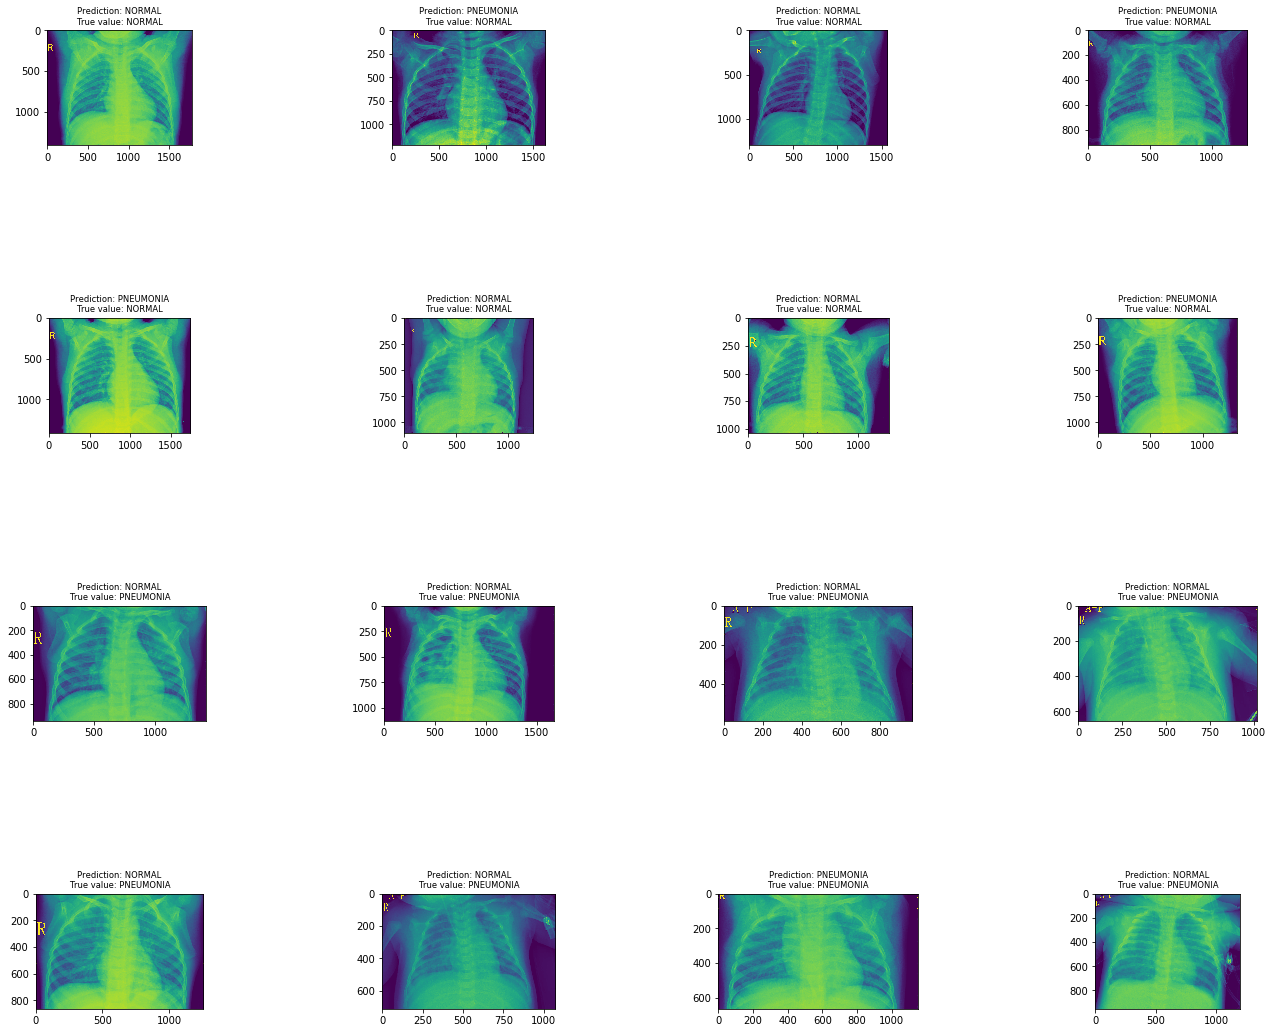

In [103]:
compare_results(validation_dir, val_generator)


ValueError: ignored

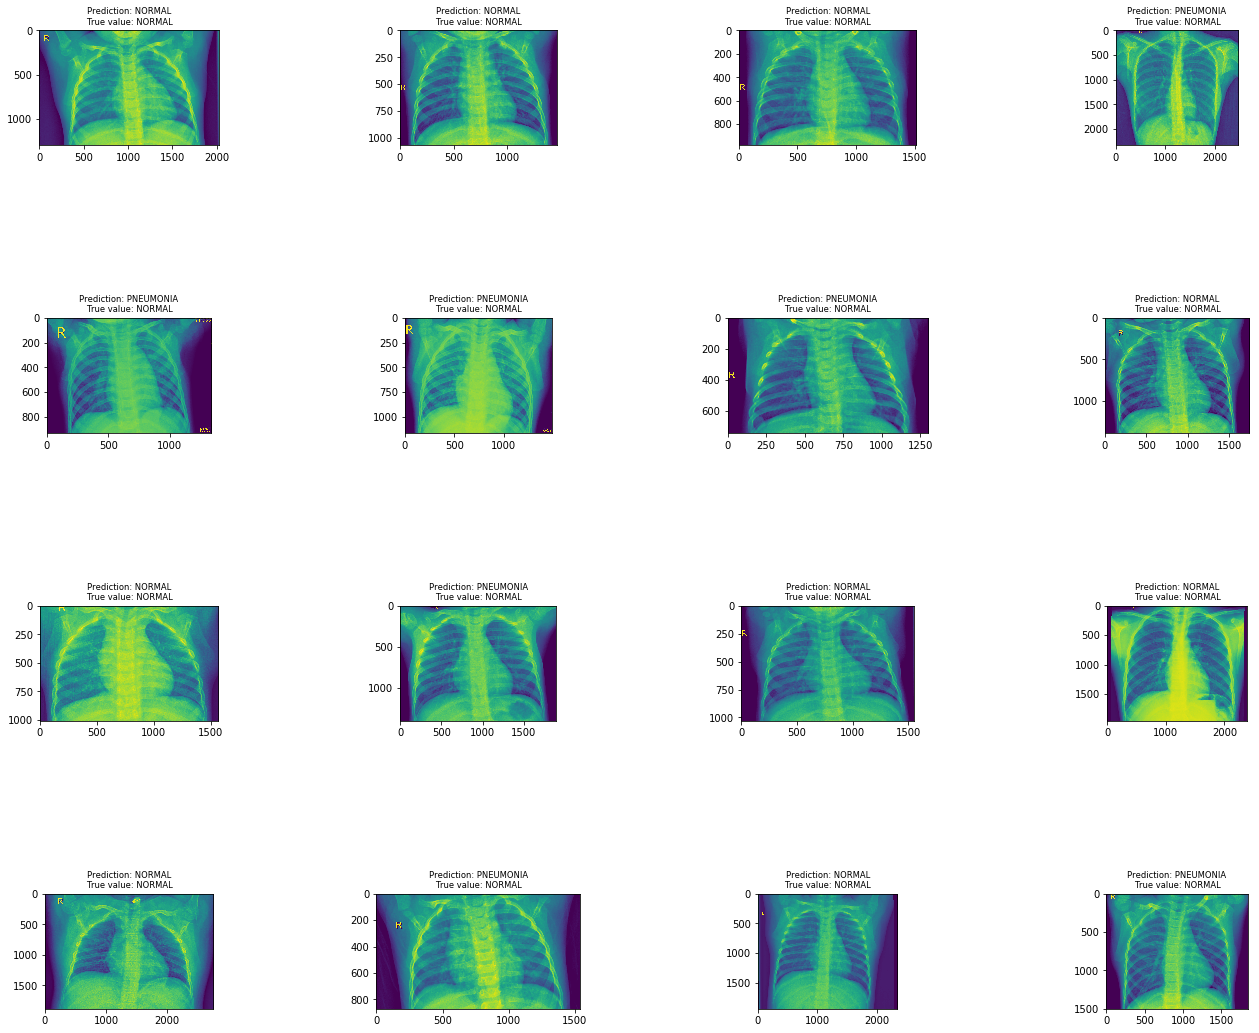

In [104]:
compare_results(testing_dir, test_generator)